# Probably Interesting Data
 - Dalton Hahn (2762306) and Ron Andrews (1083734)
## Localization Data for Posture Reconstruction

### Build a heuristic to model the data using mixture models of probability distributions programmatically
https://www.kaggle.com/uciml/posture-reconstruction

**An important note is that the .zip file provided on kaggle and the .zip file that we utilize in the pandas read_csv() call are different.  In order to properly read in the data using pandas, we opened the .zip archive provided from kaggle and removed a README file present within the directory.  From there, we simply re-compressed the file and uploaded it within the /data/external/ directory.  The .zip present within this Github repository is the correct .zip archive that functions correctly with our program. **



## Madness Method
We will first investigate the data available in the kaggle dataset for posture recognition in elderly people.  The data was collected from various sensors present upon subject's bodies.  We begin first by searching for interesting features present in the data.

Once an area of focus has been established, we begin the normalization process using Gaussian Normal Distribution Functions.



Timbre from various songs over time to identify the trends in the data - looking for interesting features in the data.
Once we have determined the values of focus, we will normalize the data using a Guassian Normal Distribution Function.
With the normalized model data, we will plot the values, looking for interesting trends in the data. We will remove data that is uninteresting (few characteristics) or which go out of bounds from the more 'normal' dataset.
At the end, with our final collection of data parameters, we will plot a mean function against the data to see where the moderate pattern lies.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statistics import mean, stdev

## Read in the data

In [2]:
df = pd.read_csv("../data/external/ConfLongDemo_JSI.csv.zip", compression="zip")

In [3]:
df.head(1)

,A01,010-000-024-033,633790226051280329,27.05.2009 14:03:25:127,4.062931060791016,1.8924342393875122,0.5074254274368286,walking
0,A01,020-000-033-111,633790226051820913,27.05.2009 14:03:25:183,4.291954,1.78114,1.344495,walking


## Feature Engineering

In [4]:
df[df.columns[7]].unique()

array(['walking', 'sitting down', 'sitting', 'standing up from sitting',
       'falling', 'lying', 'standing up from lying', 'lying down',
       'sitting on the ground', 'standing up from sitting on the ground',
       'on all fours'], dtype=object)

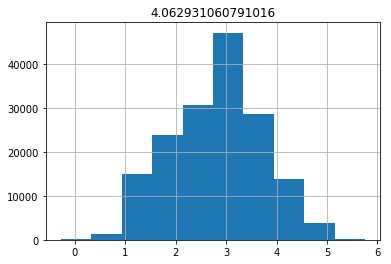

In [5]:
hist = df.hist(column = df.columns[4])

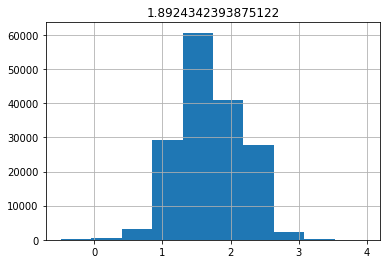

In [6]:
hist = df.hist(column = df.columns[5])

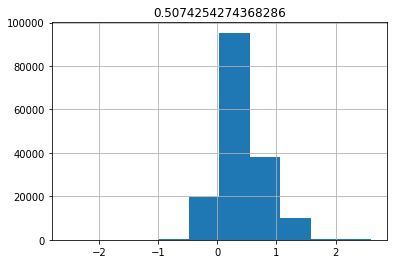

In [7]:
hist = df.hist(column = df.columns[6])

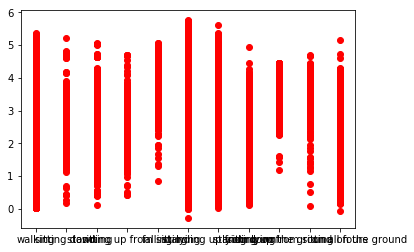

In [8]:
plt.plot(df['walking'], df['4.062931060791016'], 'ro')
plt.show()

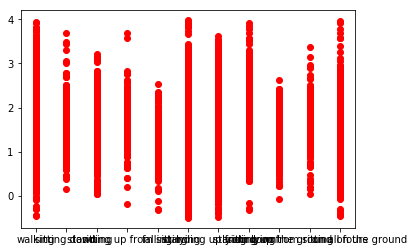

In [9]:
plt.plot(df['walking'], df['1.8924342393875122'], 'ro')
plt.show()

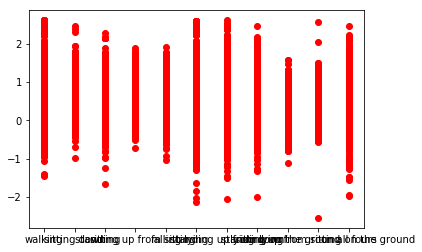

In [10]:
plt.plot(df['walking'], df['0.5074254274368286'], 'ro')
plt.show()

Based on observation from the above graphs, we decided to focus on the relationship between the X,Y,Z positions of the data relative to the "posture" of the subject

In [11]:
def gaus_mixed(df):
    ## Go through the dataframe and tabulate
    ## Init
    mixed = [0 for _ in range(df.shape[0])]
    counter = 0
    mixed_df = pd.DataFrame()
    for index, row in df.iterrows():
        for i in range(len(likely)):
            mixed[counter] += row['TimbreAvg'+str(i+1)] *likely[i]
        counter += 1
    mixed_df['Year'] = gauss_df['Year']
    mixed_df['MIXED'] = mixed
    
    return(mixed_df)

In [12]:
def vector_magnitude(x,y,z):
    return(math.sqrt((x**2)+(y**2)+(z**2)))

In [13]:
#Iterate through each row and pass the vector_magnitude function the x,y,z values
#Create new dataframe that will hold datetime, label, and the magnitude
#df['walking'].unique().tolist()

vector_array = []
cols = df['walking'].unique().tolist()
for index,row in df.iterrows():
    for col in cols:
        if col in row[7] and len(col) == len(row[7]):
            vector_array.append( {
                'datetime': row[3],
                col: vector_magnitude(row[4],row[5],row[6])
            })

In [14]:
vector_df = pd.DataFrame(vector_array)
vector_df.head()

,datetime,falling,lying,lying down,on all fours,sitting,sitting down,sitting on the ground,standing up from lying,standing up from sitting,standing up from sitting on the ground,walking
0,27.05.2009 14:03:25:183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.837457
1,27.05.2009 14:03:25:210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.824554
2,27.05.2009 14:03:25:237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.523590
3,27.05.2009 14:03:25:263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.820194
4,27.05.2009 14:03:25:290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.884659


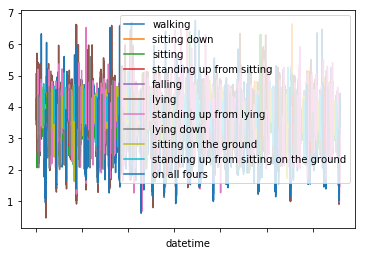

In [15]:
vector_df.plot(x='datetime', y=cols)
plt.show()

## Work the data into a Mixed Guassian Model

#### Guassian Transformation
The following function, gauss_transform, goes through the dataset and normalizes all of the values using a Gaussian distribution function: 
$\Large \mathcal{N}(x|\mu,\sigma^2) = \frac{1}{\sigma \sqrt{2 \pi}}    e^{-\frac{(x - \mu)^2}{2 (\mu^2)}}$

In [16]:
def gauss_transform(col):
    
    cleanCol = [x for x in col if str(x) != 'nan']

    result_arr = []
    
    mu = mean(cleanCol)
    sig = stdev(cleanCol)
    frac_part = 1/(sig*math.sqrt(2*math.pi))
    for val in col:
        if val != 'nan':
            exponent_part = ((val - mu)**2) / (2*(mu**2)) * -1
            result_arr.append(frac_part * math.exp(exponent_part))
    return result_arr
        

### Maximum Likelihood for Gaussian Distribution
As per Bishop, the simple form for calculating likelihood is:
$\Large \mu = \frac{1}{N}\Sigma_{n=1}^{N}x_n$ a.k.a. $\Large \pi_k$

In [17]:
def likelihood(col):
    
    cleanCol = [x for x in col if str(x) != 'nan']
    
    return sum(col) / len(cleanCol)

### Perform Guassian Transformation on each column (Posture)

In [18]:
vector_df.head()

,datetime,falling,lying,lying down,on all fours,sitting,sitting down,sitting on the ground,standing up from lying,standing up from sitting,standing up from sitting on the ground,walking
0,27.05.2009 14:03:25:183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.837457
1,27.05.2009 14:03:25:210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.824554
2,27.05.2009 14:03:25:237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.523590
3,27.05.2009 14:03:25:263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.820194
4,27.05.2009 14:03:25:290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.884659


In [ ]:
## Init
gauss_df = pd.DataFrame()
likely = [0 for _ in cols]
gauss_df['datetime'] = vector_df['datetime']
for i in range(len(cols)):
    ## Pass each column to the transformation function
    gauss_df[cols[i]] = gauss_transform(vector_df[cols[i]].values.tolist())
    likely[i-1] = likelihood(gauss_df[cols[i]].values.tolist())

### Generate the mixed model - Mixture of Gaussians
$\Large p(x) = \Sigma_{k=1}^{K}\pi_k \mathcal{N}(x|\mu_k,{\small \Sigma}_k)$

In [ ]:
## Go through the dataframe and tabulate
## Init
mixed = [0 for _ in range(gauss_df.shape[0])]
counter = 0
mixed_df = pd.DataFrame()
for index, row in gauss_df.iterrows():
    for i in range(len(likely)):
        mixed[counter] += row[cols[i]] *likely[i]
    counter += 1
mixed_df['datetime'] = gauss_df['datetime']
mixed_df['MIXED'] = mixed

In [ ]:
print(gauss_df.head(1))

In [ ]:
cols.append('MIXED')
gauss_df['MIXED'] = mixed_df['MIXED']
gauss_df.plot(figsize=(14, 10), x='datetime', y=cols)
plt.show()